# Projet de reconnaissance faciale

# Reconnaissance faciale avec TensorFlow

## Preparation des données

In [1]:
#import tensorflow as tf
#from tensorflow.keras.preprocessing import image_dataset_from_directory
#
## Charger le dataset
#dataset_path = "dataset"
#batch_size = 32
#img_height = 224
#img_width = 224
#
#train_dataset = image_dataset_from_directory(
#    dataset_path,
#    validation_split=0.2,
#    subset="training",
#    seed=123,
#    image_size=(img_height, img_width),
#    batch_size=batch_size
#)
#
#val_dataset = image_dataset_from_directory(
#    dataset_path,
#    validation_split=0.2,
#    subset="validation",
#    seed=123,
#    image_size=(img_height, img_width),
#    batch_size=batch_size
#)
#
## Récupérer les noms de classes avant la transformation
#class_names = train_dataset.class_names
#print("Class names:", class_names)
#
## Normaliser les images
#normalization_layer = tf.keras.layers.Rescaling(1./255)
#
## Appliquer la normalisation
#train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [2]:
import os
import re

import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.python.layers.core import dropout

# Paramètres
dataset_path = "dataset"
batch_size = 32
img_height = 224
img_width = 224

# Fonction pour organiser les images par angles avec diagnostic
def organize_images_by_angles(class_path):
    angles = {
        'face': [],
        'left': [],
        'right': [],
        'up': [],
        'down': []
    }

    for img_file in os.listdir(class_path):
        # Extraire le numéro de l'image
        try:
            # Utiliser une expression régulière plus flexible
            match = re.search(r'face_(\d+)', img_file)
            if match:
                num = int(match.group(1))
                full_path = os.path.join(class_path, img_file)

                if 0 <= num <= 4:
                    angles['face'].append(full_path)
                elif 5 <= num <= 9:
                    angles['left'].append(full_path)
                elif 10 <= num <= 14:
                    angles['right'].append(full_path)
                elif 15 <= num <= 19:
                    angles['up'].append(full_path)
                elif 20 <= num <= 24:
                    angles['down'].append(full_path)
        except (ValueError, TypeError):
            # Ignorer les fichiers qui ne correspondent pas au motif
            continue

    return angles

# Récupérer les noms de classes
class_names = os.listdir(dataset_path)
class_names = [nom for nom in class_names if os.path.isdir(os.path.join(dataset_path, nom))]

# Préparation des données
images = []
labels = []
image_paths = []

for classe, nom in enumerate(class_names):
    class_path = os.path.join(dataset_path, nom)

    # Organiser les images par angles
    angles_images = organize_images_by_angles(class_path)

    # Vérifier que chaque catégorie a des images
    val_images = []
    for angle in ['face', 'left', 'right', 'up', 'down']:
        if angles_images[angle]:
            val_images.append(np.random.choice(angles_images[angle], 1)[0])
        else:
            print(f"ATTENTION : Pas d'image pour l'angle {angle} dans {nom}")

    # Vérifier qu'on a bien des images de validation
    if not val_images:
        print(f"ERREUR : Aucune image de validation pour {nom}")
        continue  # Passer à la classe suivante

    # Charger les images de validation
    for val_path in val_images:
        try:
            img = image.load_img(val_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img)

            images.append(img_array)
            labels.append(classe)
            image_paths.append(val_path)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {val_path}: {e}")

    # Charger les images d'entraînement (les autres)
    train_images = [
        path for angle_list in angles_images.values() for path in angle_list
        if path not in val_images
    ]

    for train_path in train_images:
        try:
            img = image.load_img(train_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img)

            images.append(img_array)
            labels.append(classe)
            image_paths.append(train_path)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {train_path}: {e}")

# Convertir en numpy arrays
images = np.array(images)
labels = np.array(labels)
image_paths = np.array(image_paths)

# Normalisation
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_dataset = (train_dataset
    .batch(batch_size)
    .map(lambda x, y: (normalization_layer(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

# Créer le dataset de validation en prenant 1 image sur 6 (les images de validation)
val_images = images[::6]
val_labels = labels[::6]

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = (val_dataset
    .batch(batch_size)
    .map(lambda x, y: (normalization_layer(x), y))
    .prefetch(tf.data.AUTOTUNE)
)

# Afficher les fichiers de validation
print("\nFichiers de validation :")
for classe in range(len(class_names)):
    print(f"\nClasse {class_names[classe]} :")
    classe_val_paths = image_paths[(labels == classe) & (np.array([path in image_paths[labels == classe][0:5] for path in image_paths]))]
    for path in classe_val_paths:
        print(os.path.basename(path))

# Autres informations de distribution
print("\nNoms des classes:", class_names)
print("Nombre total d'images:", len(images))
print("Nombre d'images par classe:", len(images) // len(class_names))
print("\nNombre d'images d'entraînement:", len(train_dataset) * batch_size)
print("Nombre d'images de validation:", len(val_dataset) * batch_size)


Fichiers de validation :

Classe Edwin_Treny :
face_2.jpg
face_5.jpg
face_11.jpg
face_18.jpg
face_21.jpg

Classe Franck_Tene :
face_2.jpg
face_7.jpg
face_10.jpg
face_17.jpg
face_21.jpg

Classe Mathis_Wauters :
face_0.jpg
face_7.jpg
face_14.jpg
face_19.jpg
face_20.jpg

Classe Samuel_Jarjanette :
face_2.jpg
face_6.jpg
face_11.jpg
face_17.jpg
face_20.jpg

Noms des classes: ['Edwin_Treny', 'Franck_Tene', 'Mathis_Wauters', 'Samuel_Jarjanette']
Nombre total d'images: 100
Nombre d'images par classe: 25

Nombre d'images d'entraînement: 128
Nombre d'images de validation: 32


## Définir le modèle

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Charger MobileNetV2 sans la dernière couche
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Geler les couches du modèle pré-entraîné
base_model.trainable = False

# Ajouter des couches personnalisées
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']),

# Résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Data augmentation et entraînement du modèle

In [4]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    ])

# Appliquer la data augmentation
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 876ms/step - accuracy: 0.1871 - loss: 2.4696 - val_accuracy: 0.3529 - val_loss: 1.2104
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - accuracy: 0.3205 - loss: 1.5037 - val_accuracy: 0.5882 - val_loss: 0.9511
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.4606 - loss: 1.2617 - val_accuracy: 0.7647 - val_loss: 0.8100
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.5220 - loss: 1.1125 - val_accuracy: 0.7647 - val_loss: 0.7039
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.5253 - loss: 1.0706 - val_accuracy: 0.8824 - val_loss: 0.6064
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.5836 - loss: 0.8918 - val_accuracy: 0.8824 - val_loss: 0.5150
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.7288 - loss: 0.7756 - val_accuracy: 1.0000 - val_loss: 0.4447
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.7068 - loss: 0.6861 - val_accuracy: 1.0000 - val_loss:

## Visualisation des résultats

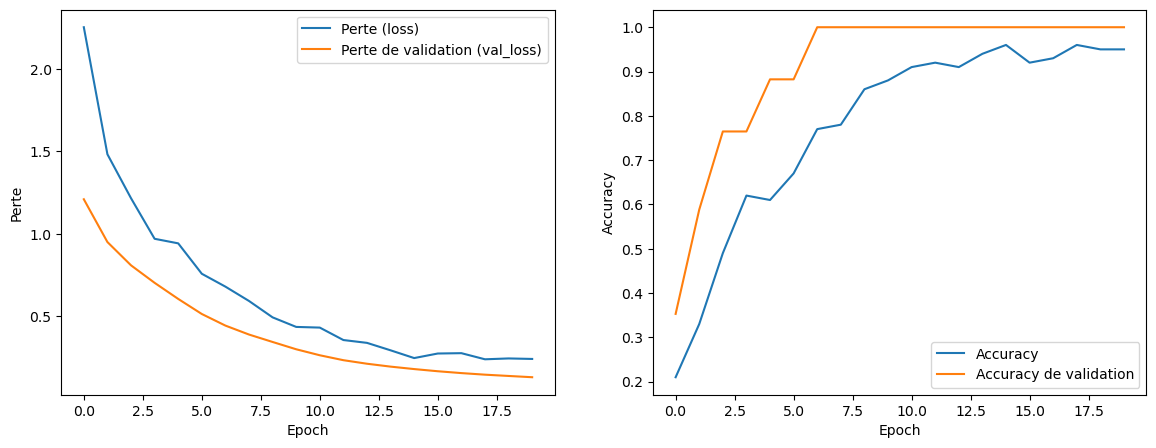

In [5]:
## Visualisation des résultats
import matplotlib.pyplot as plt

# Afficher la perte et l'accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (loss)')
plt.plot(history.history['val_loss'], label='Perte de validation (val_loss)')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Afficher l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy de validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Évaluer le modèle et ajuster les hyperparamètres

In [6]:
model.save("face_recognition_model.keras")


## Reconnaissance faciale en temps réel

In [9]:
import cv2
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
import os
import tkinter as tk
from tkinter import Tk, Label
from tkinter import simpledialog
from tkinter import messagebox

# Charger le modèle sauvegardé
model = tf.keras.models.load_model("face_recognition_model.keras")

# Initialiser le classificateur de visage d'OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Dimensions des images attendues
img_height = 224
img_width = 224

# Fonction pour effectuer une prédiction
def predict_face(face, model, class_names):
    face = cv2.resize(face, (img_width, img_height))  # Redimensionner
    face_array = img_to_array(face) / 255.0  # Normaliser
    face_array = np.expand_dims(face_array, axis=0)  # Ajouter une dimension batch
    predictions = model.predict(face_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

def show_message(message, duration=5):
    """
    Affiche un message dans une fenêtre pendant une durée spécifiée.
    """
    root = Tk()
    root.title("Prochaine étape")
    root.geometry("300x100")
    label = Label(root, text=message, font=("Helvetica", 16), wraplength=280)
    label.pack(expand=True)
    root.after(duration * 1000, root.destroy)  # Ferme la fenêtre après `duration` secondes
    root.mainloop()

def capture_face(prenom, nom):
    # Créer le dossier pour enregistrer les images si il n'existe pas
    folder_name = f"dataset/{prenom}_{nom}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Ouvrir la caméra
    cap = cv2.VideoCapture(0)
    captured_images = 0
    directions = ["Regardez a gauche", "Regardez a droite", "Regardez vers le haut", "Regardez vers le bas", "Regardez droit devant"]
    images_per_direction = 1  # Nombre d'images par direction
    total_images = len(directions) * images_per_direction

    direction_index = 0

    while captured_images < total_images:
        # Afficher le texte de l'étape actuelle
        current_direction = directions[direction_index]
        print(f"Etape : {current_direction}")

        # Pause de 3 secondes avec affichage de l'étape actuelle
        for i in range(3, 0, -1):
            ret, frame = cap.read()
            if not ret:
                break
            # Ajouter le texte pour guider l'utilisateur
            cv2.putText(frame, f"{current_direction} dans {i} secondes",
                        (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.imshow('Capturer le visage', frame)
            cv2.waitKey(1000)

        # Capturer les 50 images pour cette étape
        while captured_images < (direction_index + 1) * images_per_direction:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir en niveaux de gris pour la détection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Détection des visages
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            for (x, y, w, h) in faces:
                # Extraire le visage
                face = frame[y:y+h, x:x+w]

                # Enregistrer l'image
                face_filename = f"{folder_name}/face_{captured_images}.jpg"
                cv2.imwrite(face_filename, face)
                captured_images += 1

                # Ajouter un rectangle et des informations à l'écran
                cv2.putText(frame, f"Image {captured_images}/{total_images}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Afficher l'étape actuelle pendant la capture
            cv2.putText(frame, f"Etape actuelle : {current_direction}",
                        (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

            # Afficher le flux vidéo avec les visages détectés
            cv2.imshow('Capturer le visage', frame)

            # Quitter avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return

        # Passer à la prochaine direction
        direction_index = (direction_index + 1) % len(directions)

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()
    show_message(f"Enregistrement terminé. Les visages ont été enregistrés dans le dossier : {folder_name}")

# Fonction pour analyser les visages
def analyze_face():
    cap = cv2.VideoCapture(0)

    # Dictionnaire pour stocker les données des visages détectés
    face_data = {}  # Clé : ID de visage, Valeur : {classe, score de confiance}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convertir en niveaux de gris pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Détection des visages
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Mettre à jour les données des visages
        new_face_data = {}
        for i, (x, y, w, h) in enumerate(faces):
            face_id = f"face_{i}"  # ID unique pour chaque visage détecté
            face = frame[y:y+h, x:x+w]

            # Prédire la classe et la confiance pour le visage actuel
            predicted_class, confidence = predict_face(face, model, class_names)

            # Si le visage est nouveau ou si la confiance est meilleure, mettre à jour
            if face_id not in face_data or confidence > face_data[face_id]['confidence']:
                new_face_data[face_id] = {'class': predicted_class, 'confidence': confidence}
            else:
                # Sinon, conserver les données précédentes
                new_face_data[face_id] = face_data[face_id]

            # Dessiner un rectangle autour du visage et ajouter le texte
            color = (0, 255, 0)  # Vert pour le rectangle
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            text = f"{new_face_data[face_id]['class']} ({new_face_data[face_id]['confidence']:.2f})"
            cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # Mettre à jour les données des visages
        face_data = new_face_data

        # Afficher le flux vidéo avec les prédictions
        cv2.imshow('Reconnaissance Faciale', frame)

        # Quitter avec la touche 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()

# Interface graphique avec Tkinter
def create_interface():
    # Fenêtre principale
    window = tk.Tk()
    window.title("Reconnaissance Faciale")

    # Fonction pour enregistrer un visage
    def start_capture():
        prenom = simpledialog.askstring("Prénom", "Entrez votre prénom:")
        nom = simpledialog.askstring("Nom", "Entrez votre nom:")
        if prenom and nom:
            capture_face(prenom, nom)

    # Fonction pour analyser les visages
    def start_analyze():
        analyze_face()

    # Boutons pour chaque fonctionnalité
    capture_button = tk.Button(window, text="Enregistrer un visage", command=start_capture)
    capture_button.pack(pady=10)

    analyze_button = tk.Button(window, text="Analyser un visage", command=start_analyze)
    analyze_button.pack(pady=10)

    # Lancer l'interface
    window.mainloop()

# Lancer l'interface graphique
create_interface()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━